In [3]:
"""
Compute the distance between two trajectories: the one reported by the indoor location system and the ground truth one
"""

'\n[TODO] Module docstring\n'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [5]:
class Point:
    """Two-dimensional point in Cartesian coordinate system

    Args:
        x_init (float): abscissa of the point
        y_init (float): ordinate of the point

    Attributes:
        x (float): abscissa of the point
        y (float): ordinate of the point

    """
    def __init__(self, x_init, y_init):
        self.x = x_init
        self.y = y_init

    def __repr__(self):
        return f"Point({self.x}, {self.y})"

    def __str__(self):
        return f"⟨{self.x}, {self.y}⟩"

    def __eq__(self, point):
        return abs(self.x - point.x) < 1e-6 and abs(self.y - point.y) < 1e-6

    def __add__(self, point):
        return Point(self.x + point.x, self.y + point.y)

    def __neg__(self):
        return Point(-self.x, -self.y)

    def __sub__(self, point):
        return self + (-point)

    def __mul__(self, coeff):
        return Point(self.x * coeff, self.y * coeff)

    def coordinates(self):
        """Returns the coordinates of the point into a list of two elements"""
        return [self.x, self.y]

    def distance(self, point):
        """Returns the Euclidian distance between the point and the Point point

        Examples:
        >>> np.round(Point(-8, 9 ).distance(Point( 0, 0)), 2)
        12.04
        >>> np.round(Point(10, 20).distance(Point(-4, 5)), 2)
        20.52
        >>> np.round(Point(-3, 5 ).distance(Point(-3, 5)), 2)
        0.0
        """
        return np.sqrt((self.x - point.x)**2 + (self.y - point.y)**2)

In [6]:
class Vector:
    """two-dimensional Euclidean vector
    Args:
        anchor (Point): initial point
        endpoint (Point): terminal point

    Attributes:
        x (float): scalar component along the x-axis of the vector
        y (float): scalar component along the y-axis of the vector
    """

    def __init__(self, anchor, endpoint):
        self.x = endpoint.x - anchor.x
        self.y = endpoint.y - anchor.y

    def __repr__(self):
        return f"Vector({self.x}, {self.y})"

    def __str__(self):
        return f"{{{self.x}, {self.y}}}"

    def dot(self, vector):
        """Dot product of the vector and another Vector vector"""
        return self.x * vector.x + self.y * vector.y

    def is_colinear(self, vector):
        """Check whether ot not the vector is colinear to the Vector vector"""
        return self.x * vector.y - vector.x * self.y == 0

#     def toArray(self):
#         return np.array([self.x, self.y])

In [7]:
class LineSegment:
    """real (directed) half-open line segment

    Args:
        anchor (Point): first end point of the line segment (exclude)
        endpoint (Point): second end point of the line segment (include)

    Attributes:
        anchor (Point): first end point of the line segment (exclude)
        endpoint (Point): second end point of the line segment (include)
    """
    def __init__(self, anchor, endpoint):
        self.anchor = anchor
        self.endpoint = endpoint

    def __repr__(self):
        return f"Ray({repr(self.anchor)}, {repr(self.endpoint)})"

    def __str__(self):
        return f"[{str(self.anchor)}⋯{str(self.endpoint)}]"

    @property
    def length(self):
        """Length of the line segment (i.e. distance between its endpoints)"""
        return self.anchor.distance(self.endpoint)

    def display(self, color='teal'):
        """Method used to plot the line segment"""
        x_values = [self.anchor.x, self.endpoint.x]
        y_values = [self.anchor.y, self.endpoint.y]
        plt.plot(x_values, y_values, 'o--', color=color)

    def contains(self, point):
        """Check whether or not the line segment contains the Point point

        Args:
            point (Point)

        Returns:
            bool: True if the point is contained in the line segment, False otherwise

        Examples:
        >>> LineSegment(Point(1, -2), Point(2, 0)).contains(Point(5, 6)) # working test
        False
        >>> LineSegment(Point(1, 0), Point(2, -1)).contains(Point(3, 1)) # working test
        False
        >>> LineSegment(Point(5, -1), Point(5, 4)).contains(Point(5, 0)) # vertical
        True
        """
        vec_a = Vector(self.anchor, self.endpoint)
        vec_b = Vector(self.anchor, point)
        return vec_a.is_colinear(vec_b) and 0 <= vec_a.dot(vec_b) <= vec_a.dot(vec_a)

    def line_equation_coeffs(self):
        """
        Returns:
            a, b, c (tuple of floats): Coefficients of the linear equation
                ax + by + c of the segment line
        N.B.:
            if (a, b, c) is a solution then λ(a, b, c) is also a solution

        Examples:
        >>> LineSegment(Point(3, 3),\
Point(2, 0)).line_equation_coeffs() # working test
        (-3, 1, -6)
        >>> LineSegment(Point(1, 2),\
Point(3, 2)).line_equation_coeffs() # a = 0
        (0, -2, -4)
        >>> LineSegment(Point(0, 0),\
Point(1, 3)).line_equation_coeffs() # c = 0
        (3, -1, 0)
        >>> LineSegment(Point(2, 2),\
Point(2, -1)).line_equation_coeffs()# b = 0
        (-3, 0, -6)
        """
        a = self.endpoint.y - self.anchor.y
        b = self.anchor.x - self.endpoint.x
        c = b * self.anchor.y + a * self.anchor.x
        return a, b, c

    def distance(self, point):
        """
        Returns:
            (float): Distance from a Point point to the line segment
                (considered here as a line)

        Examples:
        >>> np.round(LineSegment(Point(-1, 2), Point(2, 3)).distance(Point(1, 1)), 2)
        1.58
        >>> np.round(LineSegment(Point(0, 1), Point(0, 3)).distance(Point(-1, 0)), 2)
        1.0
        """
        a, b, c = self.line_equation_coeffs()
        return abs(b * point.y + a * point.x - c) / np.hypot(a, b)

    def intersects(self, seg):
        """Find intersection point between two oriented half-open line segments

        Since the two line segments are half-open at their endpoints:
            - If the (include) endpoints of the two line segments coincide, then
            the two line segments intersect at their endpoints
            - If the (exclude) anchors of the tow line segments coincide, then
            the two line segments DO NOT intersect at their anchors

        Args:
            seg (LineSegment): The line segment which may intersect

        Returns:
            (Point): The intersection point if the line segments intersect,
            None: otherwise

        Examples:
        >>> LineSegment(Point(-2, 2), Point(3, 4))\
.intersects(LineSegment(Point(1, 5), Point(1, 2))) # [p1, p2] and ]q1, q2[ intersect
        Point(1.0, 3.2)
        >>> LineSegment(Point(1, 2), Point(4, 2))\
.intersects(LineSegment(Point(-2,3), Point(-2,1)))
        >>> LineSegment(Point(2, 3), Point(2, 0))\
.intersects(LineSegment(Point(2, 2), Point(2, 1))) # colinear
        >>> LineSegment(Point(2, 3), Point(2, 0))\
.intersects(LineSegment(Point(1, 2), Point(1, -1))) # parallel
        """
        p1x, p1y = self.anchor.coordinates()
        p2x, p2y = self.endpoint.coordinates()
        q1x, q1y = seg.anchor.coordinates()
        q2x, q2y = seg.endpoint.coordinates()
        a = np.array([[q2x - q1x, p1x - p2x],
                      [q2y - q1y, p1y - p2y]])

        if np.linalg.det(a):  # if a is invertible (if lines intersect)
            b = np.array([p1x - q1x, p1y - q1y])
            t = np.linalg.solve(a, b)
            if np.all(t > 0) and np.all(t <= 1):  # if line segments intersect
                intersection = Point(
                    p1x + t[1] * (p2x - p1x), p1y + t[1] * (p2y - p1y))
                return intersection
        return None
    
    def intersections_with(self, traj):
        """ Find all (unordered) intersection points between the line segment and a trajectory

        Returns:
            intersect_points (list of Points): Points that are intersection between the line segment and a line segment of the Trajectory traj
            intersect_index (list of int): Indexes of the line segments of the Trajectory traj that intersect with the line segment self
        """
        intersect_points = []
        intersect_index = []
        for j, segment in enumerate(traj.get_line_segments()):
            intersection = self.intersects(segment)
            if intersection:
                intersect_points.append(intersection)
                intersect_index.append(j)
        return intersect_points, intersect_index

In [8]:
class Polygon():
    """Simple polygon (the boundary of the polygon does not cross itself

    Args:
        *points (Points): ordered vertices of the polygon
            (The first point can ben repeated at the end or not)

    Attributes:
        points (list of Points): The vertices of the polygon
            The first vertice is repeated at the end (self.points[0] == self.points[-1])
    """
    def __init__(self, *points):
        self.points = list(points)
        # we have to append the first point at the end if neccesary
        if points[-1] != points[0]:
            self.points.append(points[0])

    def __len__(self):
        return max(len(self.points) - 1, 0)

    def get_edge(self, i):
        """Returns the i-th edge of the polygon

        Args:
            i (int): the index of the edge to be returned
        Returns:
            (LineSegment): the i-th edge of the poygon
        """
        return LineSegment(self.points[i], self.points[i+1])

    def get_all_edges(self):
        """Returns all the edges of the polygon

        Returns:
            (list of LineSegments): the edges of the polygon
        """
        return [self.get_edge(i) for i in range(len(self))]

    def display(self, color='C0'):
        """Method used to plot the polygon"""
        x_values = [p.x for p in self.points]
        y_values = [p.y for p in self.points]
        plt.fill(x_values, y_values, facecolor=color, alpha=0.3)
        plt.plot(x_values, y_values, '-o', color=color)

    @property
    def area(self):
        """Compute the area of the simple polygon
        
        Proposed solution:
            For each edge of the polygon, we compute the area of the right
            trapezoid defined by this edge and its projection over the x-axis.
            If the edge is oriented towards the positive values of x, the area
            is counted positive ; the area is counted negative otherwise
        """
        area = 0

        for edge in self.get_all_edges():
            basis = (edge.endpoint.x - edge.anchor.x)
            heigth = 0.5 * (edge.endpoint.y + edge.anchor.y)
            area += basis * heigth
        return abs(area)

The last and main class defines instances of Trajectory. A trajectory is defined by all the points that constitute it. We can access a segment of the trajectory. Two compute the error between two trajectories we decided to split the two trajectories into simple polygon. The area between the two trajectories is then the accumulation of the polygons area.

The critical aspect is then to determine the points (later called cutting points) at which the trajectories are cut to create the polygons. Obviously, these cutting points are the intersection points of the two trajectories (cf method `find_intersecting_segments`). But the reverse is not true: some points of intersection are not really points of intersection. This occurs when both trajectories close and return to a place already explored in the past.

To keep only the "real" intersections, all intersections on the first trajectory (including self-intersections) are listed in order, and the same is done on the second trajectory. We compare then the intersections two by two: if an intersection is present at the same time on both trajectories, it is considered to be a real one. However, this simplistic idea does not work in some cases (When the loop is "incomplete"). This step of selecting the right intersections is performed by the method `_find_cutting_points`.

In [9]:
class Trajectory():
    """Trajectory

    Args:
        points (list of Points): ordered Points that define the trajectory
    
    Attributes:
        points (list of Points): ordered Points that define the trajectory
    """
    def __init__(self, points):
        self.points = points

    def get_line_segment(self, i):
        """Returns the i-th line segment of the trajectory""" 
        return LineSegment(self.points[i], self.points[i+1])

    def get_line_segments(self):
        """Returns all line segments that define the trajectory"""
        return [self.get_line_segment(i) for i in range(len(self.points) - 1)]

    def __repr__(self):
        return f"Trajectory({self.points})"

    def __str__(self):
        return "Ŧ[" + ", ".join([str(point) for point in self.points]) + "]"

    def __len__(self):
        """Number of points that constitute the trajectory"""
        return len(self.points)

    @property
    def length(self):
        """Total length of all line segments of the trajectory"""
        return sum([segment.length for segment in self.get_line_segments()])

    def display(self, color='C0'):
        """Method to plot the trajectory"""
        for segment in self.get_line_segments():
            segment.display(color)
    

    def find_intersecting_segments(self, traj):
        """ Returns the index of line segments of two trajectories that intersect
        
        Args:
            traj (Trajectory): the second trajectory that may intersect with self

        Returns:
            intersecting_seg (list of tuples of int): the intersetion points *in order* on the trajectories. Each intersection is representred as a tuple: the index of line segments of the two trajectectories which intersect each other (or a self intersecting 

        """
        intersecting_seg = []
        for i, segment in enumerate(self.get_line_segments()):
            intersections_traj, intersec_index_traj = segment.intersections_with(traj)
            intersections_self, intersec_index_self = segment.intersections_with(self)

            # Get all intersection points with segment and the index of the intersection line segments
            intersec_points = intersections_traj + intersections_self
            intersec_index = [(i, j) for j in intersec_index_traj] + [(-i, -j) for j in intersec_index_self]

            # We have now to sort the intersection points on this segment
            # (with relation to the distance between the intersection point and the anchoir of the line segment)
            if len(intersec_index) > 0:
                distances = [point.distance(segment.anchor) for point in intersec_points]
                intersec_index_sorted = [i for _,i in sorted(zip(distances, intersec_index), key=lambda pair: pair[0])]
                intersecting_seg.extend(intersec_index_sorted)
        return intersecting_seg

    def _find_cutting_points(self, trajectory):
        """Find 'real' intersections between to trajectories

        Args:
            trajectory (Trajectory): the second trajectory

        Returns:
            I (list of Points): list of 'real' intersections
            cutting_segments(list of two lists): index of segments that intersect for the two trajectories:
                cutting_points[0][i] is a list of two elements [si, ti] : si is the index of a segment of self that intersects with ti another segment
        """
        inters_self = self.find_intersecting_segments(trajectory)
        inters_traj = trajectory.find_intersecting_segments(self)

        # Initializing the list of intersection points
        I = [(self.points[0] + trajectory.points[0])*0.5]

        # Selectioning 'real' intersection points
        cutting_segments = [[0], [0]] # cutting points on self and trajectory
        for i, (s, t) in enumerate(zip(inters_self, inters_traj)):
            # if the i-th intersection on self is the i-th intersection on trajectory
            if s[0] == t[1] and s[1] == t[0]:
                cutting_segments[0].append(s[0]+1) # add a cutting point for self
                cutting_segments[1].append(s[1]+1) # add a cutting point for trajectory
                # add an intersection point
                intersection = self.get_line_segment(s[0]).intersects(
                    trajectory.get_line_segment(s[1]))
                I.append(intersection)
        # We had the following cutting point and intersection point to deal with the end of the trajectories
        cutting_segments[0].append(len(self))
        cutting_segments[1].append(len(trajectory))
        I.append((self.points[-1] + trajectory.points[-1])*0.5)
        return I, cutting_segments


    def error_with(self, trajectory, display=False):
        """Compute the error between two trajectories
        
        Args:
            trajectory (Trajectory): the second trajectory
            display (bool): mode for ploting

        Returns:
            (float): the (normalized) area between the two trajectories
        """
        assert len(self) >= 2 and len(
            trajectory) >= 1, "IncorrectInputTrajectories"
        error = 0

        I, (s, t) = self._find_cutting_points(trajectory)

        # Split the two trajectories in multiple polygons
        for i in range(len(I) - 1):
            s_path = self.points[s[i]: s[i+1]]
            t_path = trajectory.points[t[i]: t[i+1]][::-1]
            # We compute the area of the polygon between two intersection points
            polygon = Polygon(I[i], *s_path, I[i+1], *t_path)
            error += polygon.area
            if display:
                polygon.display(f"C{i%5}")
        
        return error / self.length


In [10]:
def fetch_data(filename, contains_solution=True, sep=','):
    """ Fetching trajectories data from a text file

    Args:
        filename (str): the name of the files which stores the data
        contains_solution (bool): True if the file contains the expected solution
        sep (str): separator used so store data

    File Structure: A file that represents a test sample, has this following format:
        0, 1, 2, 3, 4	# abscissa of the points of the real trajectory
        0, 0, 1, 1, 0	# ordinate of the points of the real trajectory
        0, 1, 2, 3	    # abscissa of the points reported by the location system
        3, 3, 2, 2   	# ordinate of the points reported by the location system
        # if the file stores the expected error between the trajectories:
        9.333			# expected result
        0.001           # epsilon: precision of the result

    Returns:
        filename (str): the filename
        reference (Trajectory): the reference trajectory
        acquired (Trajectory): the acquired trajectory
    if contains_solution:
        expected_output (float): the expected output stored in the file
        epsilon (float): the precision of the result

    Examples:
    >>> fetch_data("tests/shared-oracles/Oracles/CorrectInputTrajectories/\
10_parallelTrajectories.txt")[1:]
    [Trajectory([Point(1.0, 1.0), Point(3.0, 1.0)]), \
Trajectory([Point(1.0, 2.0), Point(3.0, 2.0)]), 1.0, 0.001]
    >>> fetch_data("tests/shared-oracles/Oracles/IncorrectInputTrajectories/\
3_EmptyAcquiredTrajectory.txt", False)[1:]
    [Trajectory([Point(0.0, 0.0), Point(1.0, 0.0)]), \
Trajectory([])]
    >>> fetch_data("tests/shared-oracles/Oracles/IncorrectInputTrajectories/\
2_EmptyAcquiredTrajectory.txt", False)[1:]
    [Trajectory([Point(0.0, 1.0)]), Trajectory([])]
    """
    with open(filename, "r") as file:
        lines = file.read().splitlines()  # getting rid of \n
        data = [[float(n) for n in line.split(sep) if n]
                for line in lines]  # parse data

    # line 0 : x-axis of the reference trajectory, line 1 : y-axis
    reference_coord = list(zip(data[0], data[1]))
    # line 2 : x-axis of the acquired trajectory, line 3 : y-axis
    acquired_coord = list(zip(data[2], data[3]))
    reference = Trajectory([Point(x, y) for x, y in reference_coord])
    acquired = Trajectory([Point(x, y) for x, y in acquired_coord])

    if contains_solution:
        expected_output, = data[4] if len(data) > 4 else [-1]
        epsilon, = data[5] if len(data) >5 else [-1]
        return [filename, reference, acquired, expected_output, epsilon]
    return [filename, reference, acquired]

1.2729713668976308
0.5496327358176604


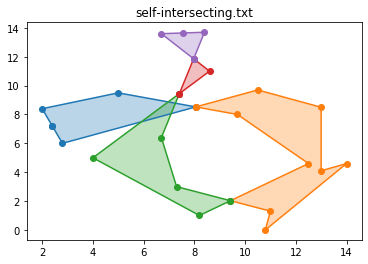

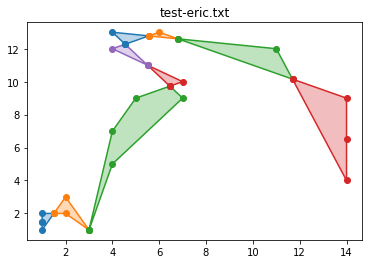

In [11]:
if __name__ == "__main__":
    # DIRNAME = "tests/shared-oracles/Oracles/EvaluationTrajectories"
    # FILENAME = "/oracle_etienne.txt"
    DIRNAME = "tests/perso-tests/"
    for file in listdir(DIRNAME):
        plt.figure()
        filename, A, B = fetch_data(DIRNAME + file, False)
        # inside notebook: to use the Trajectory class defined in notebook,
        # instead of using the one given by the estimator.py
        A, B = Trajectory(A.points), Trajectory(B.points)
        print(A.error_with(B, display=True))
        plt.title(filename.split("/")[-1])